# **CUDA-Q Basics**

This notebook is designed for learning CUDA-Q fundamentals, from single-qubit basics to multi-qubit, superposition, entanglement, and advanced kernel programming.

## Table of Contents
1. Introduction to Quantum Computing and CUDA-Q
2. Single-Qubit States, Operations, and Visualization
3. First Quantum Programs: Bit Flip, Superposition, and Measurement
4. Multi-Qubit Programming with Entanglement
5. Nested quantum kernels
6. Advanced CUDA-Q Kernels: Adjoint, Conditionals, and Variational Algorithms

---

## 1. Introduction to Quantum Computing and CUDA-Q

This section introduces the fundamental concepts of quantum computing, the motivation for quantum programming, and the CUDA-Q platform. It sets the stage for hands-on exploration with single and multi-qubit systems, quantum gates, and measurement. Simply setup the CUDA-Q by:

In [1]:
import cudaq

## 2. Single-Qubit States, Operations, and Visualization

- Quantum state initialization
- Bloch sphere representation
- Visualizing quantum states with CUDA-Q

### Example: Defining and Visualizing the Minus State


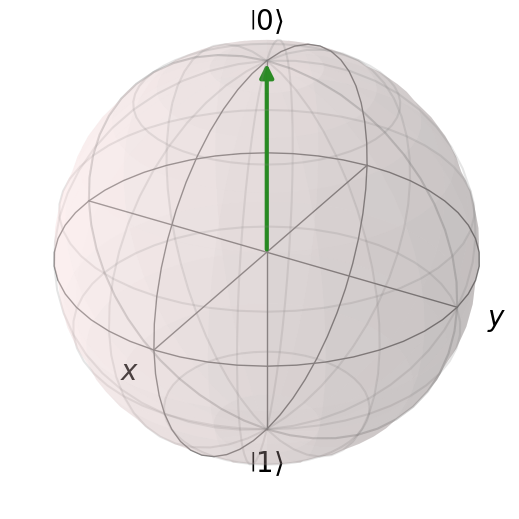

In [2]:
# Define coefficients for the zero state: |0⟩
c = [complex(1, 0), complex(0, 0)]

@cudaq.kernel
def zero_state():
    q = cudaq.qvector(c)


# Visualize the state on the Bloch sphere
sphere = cudaq.add_to_bloch_sphere(cudaq.get_state(zero_state))
cudaq.show(sphere)

## 3. First Quantum Programs: Bit Flip, Superposition, and Measurement

- Structure of a quantum program
- Bit flip (X gate)
- Superposition (Hadamard gate)
- Measurement and sampling

### Example: Bit Flip Program


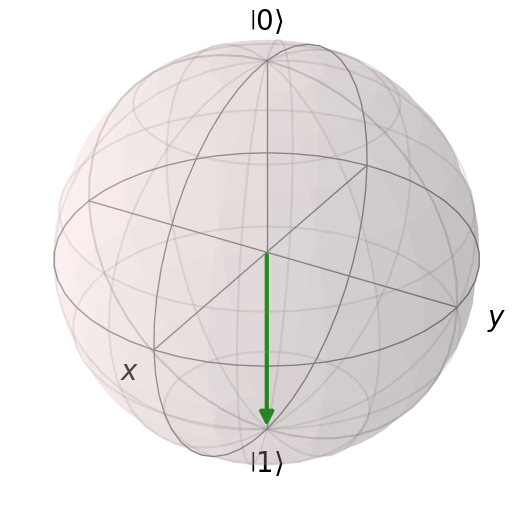

Result from sampling 1000 times: { 1:1000 }

Most probable result: 1
Measured with probability 1.0


In [3]:
@cudaq.kernel
def bitflip():
    qubit = cudaq.qvector(1)
    x(qubit[0])


# Visualize the state after the X gate
sphere = cudaq.add_to_bloch_sphere(cudaq.get_state(bitflip))
cudaq.show(sphere)

# Sample the kernel
shots = 1000
result = cudaq.sample(bitflip, shots_count=shots)
print(f"Result from sampling {shots} times: {result}")
print(f"Most probable result: {result.most_probable()}")
print(f"Measured with probability {result.probability(result.most_probable())}")

### Example: Superposition and Measurement

- Hadamard gate to create |+⟩ = (1/√2)|0⟩ + (1/√2)|1⟩
- Sampling to observe probabilistic outcomes

In [4]:
@cudaq.kernel
def plus_kernel():
    qubit = cudaq.qubit()
    h(qubit)
    mz(qubit)


print(cudaq.draw(plus_kernel))

shots = 1000
result = cudaq.sample(plus_kernel, shots_count=shots)
print("The sampling result:", result)

     ╭───╮
q0 : ┤ h ├
     ╰───╯

The sampling result: { 0:509 1:491 }



## 4. Multi-Qubit Programming with Entanglement

- `cudaq.qvector` for multiple qubits and CNOT gates
- Entanglement demonstration

### Example: Bell State (Entanglement)

In [5]:
@cudaq.kernel
def bell_state():
    q = cudaq.qvector(2)
    h(q[0])
    x.ctrl(q[0], q[1])
    mz(q)


print(cudaq.draw(bell_state))

shots = 1000
result = cudaq.sample(bell_state, shots_count=shots)
print("The sampling result:", result)

     ╭───╮     
q0 : ┤ h ├──●──
     ╰───╯╭─┴─╮
q1 : ─────┤ x ├
          ╰───╯

The sampling result: { 00:492 11:508 }



## 5. Nested CUDA-Q kernels

- **Modular programming**: Define reusable subkernels that can be called within other kernels
- **Benefits**: Improves code reusability and simplifies complex quantum circuits

In [6]:
@cudaq.kernel
def minus(qubit: cudaq.qubit):
    x(qubit)
    h(qubit)

@cudaq.kernel
def xgate(qubits: cudaq.qvector):
    x(qubits)

@cudaq.kernel
def nested_quantum_kernel(num_qubits: int):
    qvector = cudaq.qvector(num_qubits)
    xgate(qvector)
    minus(qvector[1])


num_qubits = 2
print(cudaq.draw(nested_quantum_kernel, num_qubits))

shots = 1000
result = cudaq.sample(nested_quantum_kernel, num_qubits, shots_count=shots)
print("The sampling result:", result)

     ╭───╮          
q0 : ┤ x ├──────────
     ├───┤╭───╮╭───╮
q1 : ┤ x ├┤ x ├┤ h ├
     ╰───╯╰───╯╰───╯

The sampling result: { 10:501 11:499 }



## 6. Advanced CUDA-Q Kernels: Adjoint, Conditionals, and Variational Algorithms

- Adjoint of a kernel
- Conditional operations
- Variational quantum algorithms (VQA)

### Example: Adjoint Kernel of a Rotation Gate

In [7]:
import math

@cudaq.kernel
def rotation():
    q = cudaq.qvector(1)
    rx(math.pi/4, q)

print(cudaq.draw(rotation))

@cudaq.kernel
def adjoint_rotation():
    q = cudaq.qvector(1)
    rx.adj(math.pi/4, q)

print(cudaq.draw(adjoint_rotation))

     ╭────────────╮
q0 : ┤ rx(0.7854) ├
     ╰────────────╯

     ╭─────────────╮
q0 : ┤ rx(-0.7854) ├
     ╰─────────────╯



### Example: Conditional Measurement

Quantum kernels can use mid-circuit measurement result to control subsequent operations. This example demonstrates:

1. **Measure and reset**: Apply Hadamard to qubit 0, measure it (saving result as `midCircuit`), then reset and flip to |1⟩
2. **Conditional logic**: Apply Hadamard to qubit 1 only if `midCircuit` measured 1

The result show qubit 0 is always 1 (confirming reset), while qubit 1 has a 75/25 distribution (50% chance `midCircuit`=1, then 50/50 superposition).

In [8]:
@cudaq.kernel
def kernel():
    q = cudaq.qvector(2)

    h(q[0])           # Create superposition
    midCircuit = mz(q[0])     # Measure qubit 0
    reset(q[0])       # Reset to |0⟩
    x(q[0])           # Flip to |1⟩

    if midCircuit:            # Conditional on measurement
        h(q[1])       # Create superposition on qubit 1


result = cudaq.sample(kernel)

# Access the `__global__` measurement counts
global_counts = result.get_register_counts('__global__')
print("Global counts:", global_counts)

# Access the `midCircuit` measurement counts
midCircuit_counts = result.get_register_counts('midCircuit')
print("midCircuit counts:", midCircuit_counts)

Global counts: { 10:756 11:244 }

midCircuit counts: { 0:512 1:488 }



### Example: Variational Quantum Algorithm (VQA)

Many quantum algorithms require optimizing circuit parameters to minimize expectation values. CUDA-Q provides multiple optimization approaches:

1. **Built-in CUDA-Q optimizers and gradients**
2. **Third-party optimizers** (e.g., SciPy)

In [9]:
from cudaq import spin
import numpy as np

# Define Hamiltonian for H2 molecule
hamiltonian = 5.907 - 2.1433 * spin.x(0) * spin.x(1) - 2.1433 * spin.y(0) * spin.y(1) + 0.21829 * spin.z(0) - 6.125 * spin.z(1)

@cudaq.kernel
def kernel(angles: list[float]):
    qubits = cudaq.qvector(2)
    x(qubits[0])                    # Initialize qubit 0 to |1⟩
    ry(angles[0], qubits[1])        # Variational rotation
    x.ctrl(qubits[1], qubits[0])    # CNOT gate

initial_params = np.random.normal(0, np.pi, 2)

**Method 1: Built-in CUDA-Q Optimizers**

Use CUDA-Q's built-in Adam optimizer with parameter shift:

In [10]:
optimizer = cudaq.optimizers.Adam()
gradient = cudaq.gradients.ParameterShift()

def objective_function(parameter_vector):
    # Cost function using CUDA-Q observe
    get_result = lambda params: cudaq.observe(kernel, hamiltonian, params).expectation()
    
    cost = get_result(parameter_vector)
    gradient_vector = gradient.compute(parameter_vector, get_result, cost)
    
    return cost, gradient_vector

# Optimize
energy, parameter = optimizer.optimize(dimensions=1, function=objective_function)

print(f"Minimized <H> = {round(energy, 16)}")
print(f"Optimal theta = {round(parameter[0], 16)}")

Minimized <H> = -1.748383102471307
Optimal theta = 0.5840908385816866


**Method 2: Third-Party Optimizers**

Use SciPy's optimization functions with a simple cost function:

In [11]:
from scipy.optimize import minimize

def cost(theta):
    return cudaq.observe(kernel, hamiltonian, theta).expectation()

result = minimize(cost, initial_params, method='COBYLA', options={'maxiter': 40})
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.7488650227457274
       x: [ 6.878e+00 -1.678e+00]
    nfev: 36
   maxcv: 0.0


---

## End of CUDA-Q Basics Tutorial

For further exploration, see the NVIDIA official CUDA-Q [documentation](https://nvidia.github.io/cuda-quantum/latest/index.html) and [GitHub repository](https://github.com/NVIDIA/cuda-quantum).